In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.data = []
        self.labels = []
        
        for idx, genre in enumerate(self.classes):
            genre_path = os.path.join(root_dir, genre)
            for file in os.listdir(genre_path):
                self.data.append(os.path.join(genre_path, file))
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert('RGB') 
        img = np.array(img) 
        img = img.transpose((2, 0, 1))  
        img = torch.from_numpy(img).float()  
        label = self.labels[idx]
        return img, label

# Enhanced Residual Block with Squeeze-and-Excitation
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        # Main convolution path
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        
        # Squeeze and excitation path
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        residual = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Apply SE attention
        se_weight = self.se(out)
        out = out * se_weight
        
        out += residual
        return F.relu(out)

# Enhanced CNN with deeper architecture and SE blocks
class EnhancedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        
        # Initial convolution block
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # First stage - 64 channels
        self.stage1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEResidualBlock(64),
            nn.MaxPool2d(2)
        )
        
        # Second stage - 128 channels
        self.stage2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEResidualBlock(128),
            nn.MaxPool2d(2)
        )
        
        # Third stage - 256 channels
        self.stage3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SEResidualBlock(256),
            nn.MaxPool2d(2)
        )
        
        # Adaptive pooling to handle different input sizes
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.initial(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [ ]:
# Data paths
train_dir = '/kaggle/input/mel-spectrogram-for-gtzn-dataset/melspectrograms/train'
val_dir = '/kaggle/input/mel-spectrogram-for-gtzn-dataset/melspectrograms/validation'
test_dir = '/kaggle/input/mel-spectrogram-for-gtzn-dataset/melspectrograms/test'

# Create datasets
train_dataset = MelSpectrogramDataset(train_dir)
val_dataset = MelSpectrogramDataset(val_dir)
test_dataset = MelSpectrogramDataset(test_dir)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = EnhancedCNN(dropout_rate=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# SGD optimizer with momentum and weight decay
optimizer = SGD(model.parameters(), 
               lr=0.008, 
               momentum=0.9, 
               weight_decay=2e-4)  

# OneCycleLR for potentially better convergence
scheduler = OneCycleLR(optimizer, 
                       max_lr=0.01, 
                       steps_per_epoch=len(train_loader), 
                       epochs=30,
                       pct_start=0.3)  # Warm up for 30% of training

In [3]:
# Dictionary to store metrics
metrics = {
    'train_loss': [],
    'val_loss': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Number of epochs
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for X_batch, y_batch in pbar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        loss = nn.CrossEntropyLoss()(outputs, y_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update LR using OneCycleLR
        scheduler.step()
        
        # Update running loss
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate average training loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    metrics['train_loss'].append(epoch_loss)
    print(f'Training Loss: {epoch_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc='Validation')
        for X_batch, y_batch in pbar_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = nn.CrossEntropyLoss()(outputs, y_batch)
            
            # Update validation loss
            val_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Update correct predictions count
            correct += (predicted == y_batch).sum().item()
            
            # Store predictions and true labels for metrics
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
        
        # Calculate validation metrics
        val_epoch_loss = val_loss / len(val_loader)
        accuracy = correct / len(val_dataset)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        
        # Store metrics
        metrics['val_loss'].append(val_epoch_loss)
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        
        print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Save model if it's the best so far
    if accuracy == max(metrics['accuracy']):
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved at epoch {epoch+1} with accuracy {accuracy:.4f}')

Epoch 1/30: 100%|██████████| 250/250 [02:31<00:00,  1.65it/s, loss=1.4526]


Training Loss: 2.0440


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]


Validation Loss: 1.6285, Accuracy: 0.4054, Precision: 0.4540, Recall: 0.4055, F1-Score: 0.3737
Model saved at epoch 1 with accuracy 0.4054


Epoch 2/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=1.0365]


Training Loss: 1.5342


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Validation Loss: 1.4389, Accuracy: 0.4545, Precision: 0.5040, Recall: 0.4544, F1-Score: 0.4349
Model saved at epoch 2 with accuracy 0.4545


Epoch 3/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=1.7873]


Training Loss: 1.3701


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


Validation Loss: 1.6890, Accuracy: 0.3704, Precision: 0.5234, Recall: 0.3702, F1-Score: 0.3420


Epoch 4/30: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s, loss=1.1604]


Training Loss: 1.2561


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Validation Loss: 1.3417, Accuracy: 0.5245, Precision: 0.6004, Recall: 0.5248, F1-Score: 0.4945
Model saved at epoch 4 with accuracy 0.5245


Epoch 5/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.7487]


Training Loss: 1.1644


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Validation Loss: 1.8071, Accuracy: 0.4224, Precision: 0.6149, Recall: 0.4221, F1-Score: 0.3776


Epoch 6/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.9015]


Training Loss: 1.0818


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


Validation Loss: 1.1575, Accuracy: 0.5906, Precision: 0.6475, Recall: 0.5902, F1-Score: 0.5576
Model saved at epoch 6 with accuracy 0.5906


Epoch 7/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=1.5300]


Training Loss: 1.0005


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


Validation Loss: 1.7069, Accuracy: 0.4304, Precision: 0.5987, Recall: 0.4301, F1-Score: 0.3852


Epoch 8/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=1.3461]


Training Loss: 0.9233


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


Validation Loss: 1.6992, Accuracy: 0.5075, Precision: 0.6164, Recall: 0.5079, F1-Score: 0.5046


Epoch 9/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.7821]


Training Loss: 0.8622


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Validation Loss: 0.8115, Accuracy: 0.7087, Precision: 0.7200, Recall: 0.7088, F1-Score: 0.7069
Model saved at epoch 9 with accuracy 0.7087


Epoch 10/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.9610]


Training Loss: 0.8018


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Validation Loss: 0.7743, Accuracy: 0.7417, Precision: 0.7701, Recall: 0.7418, F1-Score: 0.7492
Model saved at epoch 10 with accuracy 0.7417


Epoch 11/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.7525]


Training Loss: 0.7451


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


Validation Loss: 0.9739, Accuracy: 0.6847, Precision: 0.7272, Recall: 0.6849, F1-Score: 0.6710


Epoch 12/30: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s, loss=0.6122]


Training Loss: 0.6907


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Validation Loss: 0.8559, Accuracy: 0.6937, Precision: 0.7677, Recall: 0.6938, F1-Score: 0.6965


Epoch 13/30: 100%|██████████| 250/250 [02:08<00:00,  1.94it/s, loss=0.6023]


Training Loss: 0.6353


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


Validation Loss: 1.2307, Accuracy: 0.6336, Precision: 0.7425, Recall: 0.6337, F1-Score: 0.6317


Epoch 14/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.8618]


Training Loss: 0.6082


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Validation Loss: 1.0545, Accuracy: 0.6507, Precision: 0.7137, Recall: 0.6504, F1-Score: 0.6231


Epoch 15/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.4209]


Training Loss: 0.5673


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Validation Loss: 0.7902, Accuracy: 0.7137, Precision: 0.7624, Recall: 0.7137, F1-Score: 0.7068


Epoch 16/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.7414]


Training Loss: 0.5078


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


Validation Loss: 0.6007, Accuracy: 0.8038, Precision: 0.8240, Recall: 0.8037, F1-Score: 0.8042
Model saved at epoch 16 with accuracy 0.8038


Epoch 17/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.4850]


Training Loss: 0.4575


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Validation Loss: 0.5274, Accuracy: 0.8118, Precision: 0.8367, Recall: 0.8119, F1-Score: 0.8123
Model saved at epoch 17 with accuracy 0.8118


Epoch 18/30: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s, loss=0.3239]


Training Loss: 0.4314


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


Validation Loss: 0.7187, Accuracy: 0.7788, Precision: 0.8009, Recall: 0.7790, F1-Score: 0.7704


Epoch 19/30: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s, loss=0.1583]


Training Loss: 0.3901


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


Validation Loss: 0.5109, Accuracy: 0.8198, Precision: 0.8231, Recall: 0.8199, F1-Score: 0.8148
Model saved at epoch 19 with accuracy 0.8198


Epoch 20/30: 100%|██████████| 250/250 [02:07<00:00,  1.95it/s, loss=0.7502]


Training Loss: 0.3558


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


Validation Loss: 0.7015, Accuracy: 0.7898, Precision: 0.8172, Recall: 0.7899, F1-Score: 0.7830


Epoch 21/30: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s, loss=0.4507]


Training Loss: 0.3263


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


Validation Loss: 0.5843, Accuracy: 0.8138, Precision: 0.8415, Recall: 0.8140, F1-Score: 0.8162


Epoch 22/30: 100%|██████████| 250/250 [02:07<00:00,  1.95it/s, loss=0.1698]


Training Loss: 0.2809


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Validation Loss: 0.6529, Accuracy: 0.7938, Precision: 0.8553, Recall: 0.7940, F1-Score: 0.8002


Epoch 23/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.1357]


Training Loss: 0.2417


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Validation Loss: 0.4168, Accuracy: 0.8689, Precision: 0.8733, Recall: 0.8690, F1-Score: 0.8687
Model saved at epoch 23 with accuracy 0.8689


Epoch 24/30: 100%|██████████| 250/250 [02:08<00:00,  1.94it/s, loss=0.3732]


Training Loss: 0.2027


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


Validation Loss: 0.6876, Accuracy: 0.8178, Precision: 0.8538, Recall: 0.8178, F1-Score: 0.8171


Epoch 25/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.1618]


Training Loss: 0.1531


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Validation Loss: 0.3336, Accuracy: 0.8879, Precision: 0.8899, Recall: 0.8879, F1-Score: 0.8873
Model saved at epoch 25 with accuracy 0.8879


Epoch 26/30: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s, loss=0.1251]


Training Loss: 0.1290


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]


Validation Loss: 0.3411, Accuracy: 0.8939, Precision: 0.8987, Recall: 0.8939, F1-Score: 0.8940
Model saved at epoch 26 with accuracy 0.8939


Epoch 27/30: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s, loss=0.1087]


Training Loss: 0.0999


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


Validation Loss: 0.2945, Accuracy: 0.9219, Precision: 0.9236, Recall: 0.9220, F1-Score: 0.9222
Model saved at epoch 27 with accuracy 0.9219


Epoch 28/30: 100%|██████████| 250/250 [02:09<00:00,  1.94it/s, loss=0.0694]


Training Loss: 0.0822


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Validation Loss: 0.2817, Accuracy: 0.9179, Precision: 0.9219, Recall: 0.9180, F1-Score: 0.9192


Epoch 29/30: 100%|██████████| 250/250 [02:08<00:00,  1.94it/s, loss=0.1008]


Training Loss: 0.0638


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


Validation Loss: 0.2808, Accuracy: 0.9139, Precision: 0.9161, Recall: 0.9140, F1-Score: 0.9145


Epoch 30/30: 100%|██████████| 250/250 [02:08<00:00,  1.94it/s, loss=0.0911]


Training Loss: 0.0649


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]

Validation Loss: 0.2819, Accuracy: 0.9109, Precision: 0.9134, Recall: 0.9110, F1-Score: 0.9115


In [4]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
test_loss = 0.0
correct = 0
y_test_pred = []
y_test_true = []

with torch.no_grad():
    pbar_test = tqdm(test_loader, desc='Test')
    for X_batch, y_batch in pbar_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = nn.CrossEntropyLoss()(outputs, y_batch)
        
        # Update test loss
        test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update correct predictions count
        correct += (predicted == y_batch).sum().item()
        
        # Store predictions and true labels for metrics
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_true.extend(y_batch.cpu().numpy())
        
        # Update progress bar
        pbar_test.set_postfix({
            'Loss': f'{test_loss / (pbar_test.n + 1):.4f}', 
            'Acc': f'{correct / ((pbar_test.n + 1) * X_batch.size(0)):.4f}'
        })
    
    # Calculate test metrics
    test_accuracy = correct / len(test_dataset)
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')
    
    print(f'===== Test Results =====')
    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')

/tmp/ipykernel_19/311544630.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Test: 100%|██████████| 32/32 [00:11<00:00

===== Test Results =====
Test Loss: 0.2449
Test Accuracy: 0.9319
Test Precision: 0.9329
Test Recall: 0.9320
Test F1 Score: 0.9319


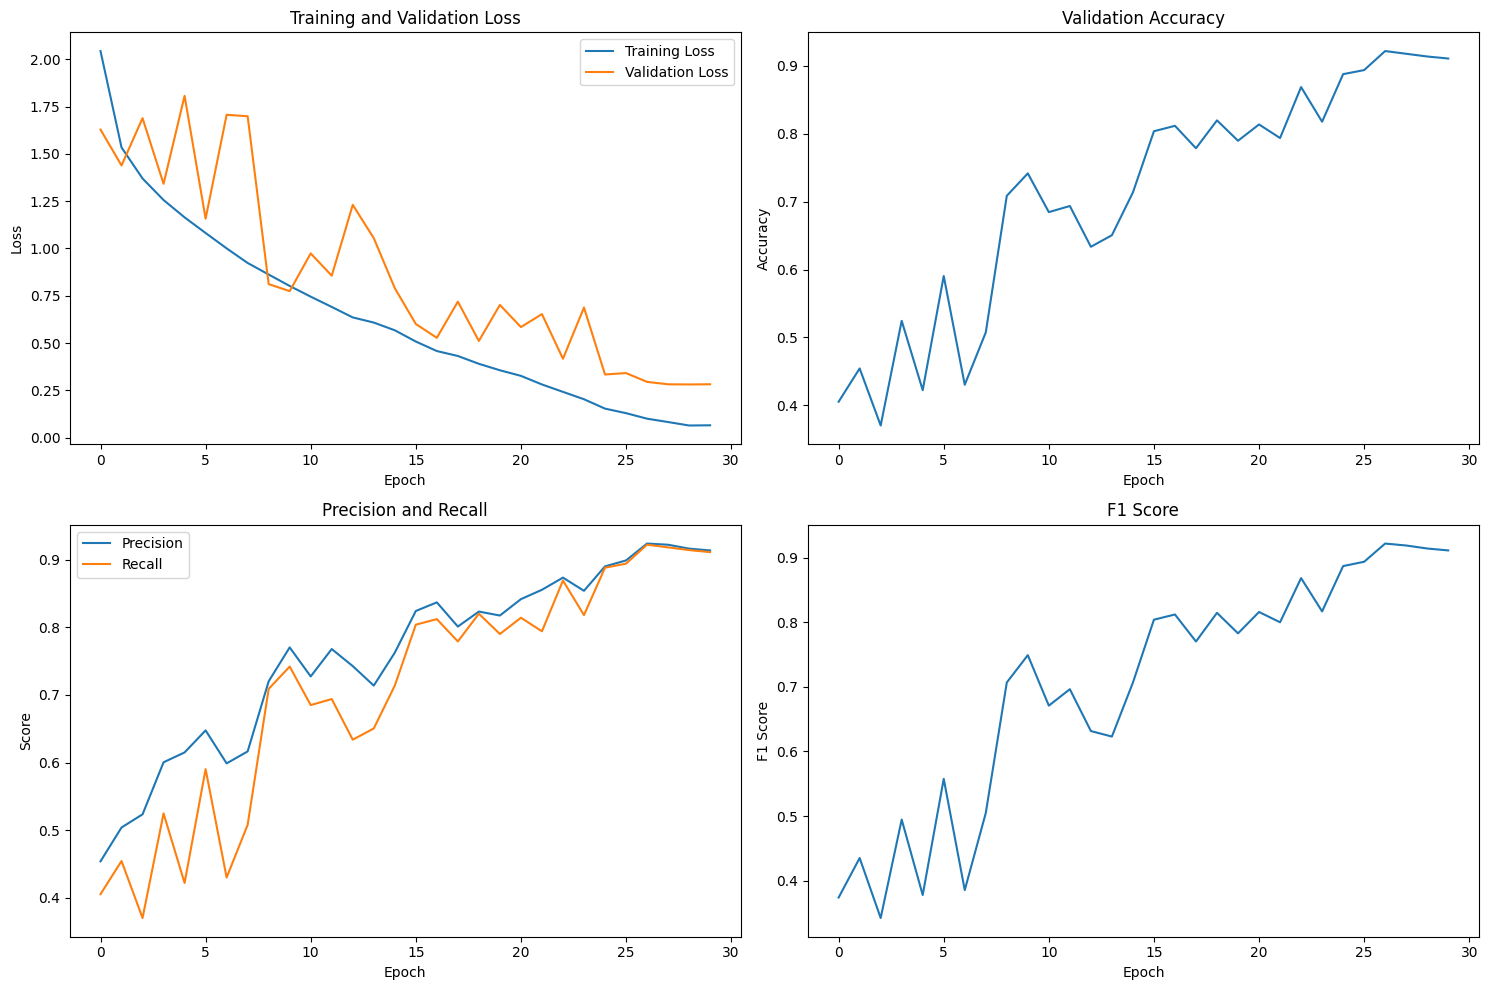

In [5]:
# Plot training metrics
plt.figure(figsize=(15, 10))

# Plot losses
plt.subplot(2, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(metrics['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

# Plot precision and recall
plt.subplot(2, 2, 3)
plt.plot(metrics['precision'], label='Precision')
plt.plot(metrics['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision and Recall')
plt.legend()

# Plot F1 score
plt.subplot(2, 2, 4)
plt.plot(metrics['f1'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()